## Statistical Test

From the exploratory analysis, we identify that sales tend to fluctuate by month and day of week, both of which are time-series components. We will access the time-series nature of the data to ensure it follows certain properties since any time-series predictive models will rely on that.

In [1]:
import chart_studio.plotly
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt, pylab
from pylab import *
import seaborn as sns
sns.set()
%matplotlib inline 

In [2]:
train_df = pd.read_csv('data/train_df.csv', parse_dates=['date'])

In [3]:
train_df.head()

,date,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_day,sales
0,2013-01-02,0,59,"Ярославль ТЦ ""Альтаир""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
1,2013-01-02,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
2,2013-01-03,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
3,2013-01-20,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
4,2013-01-23,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0


### Autocorrelation

Test if each day of sales has correlation to daily sales of another day. Resample data to test week and month. Identify lags that has the highest autocorrelation

In [4]:
ts_data = train_df[['date','sales']]

In [5]:
ts_daily = ts_data.groupby(['date'])['sales'].sum()

In [6]:
ts_weekly = ts_daily.resample(rule='W').last()
ts_monthly = ts_daily.resample(rule='M').last()

In [7]:
auto_daily = ts_daily.pct_change().autocorr()
auto_weekly = ts_weekly.pct_change().autocorr()
auto_monthly = ts_monthly.pct_change().autocorr()

In [8]:
print('Daily_autocorrelation {}'.format(auto_daily))
print('Weekly_autocorrelation {}'.format(auto_weekly))
print('Monthly_autocorrelation {}'.format(auto_monthly))

Daily_autocorrelation -0.08463005530311793
Weekly_autocorrelation -0.23559041330362235
Monthly_autocorrelation -0.21480875731501684


The daily autocorrelation (~8%) is only 1/3 of what weekly and monthly have. We will observe closely on the autocorrelation magnitude of each.

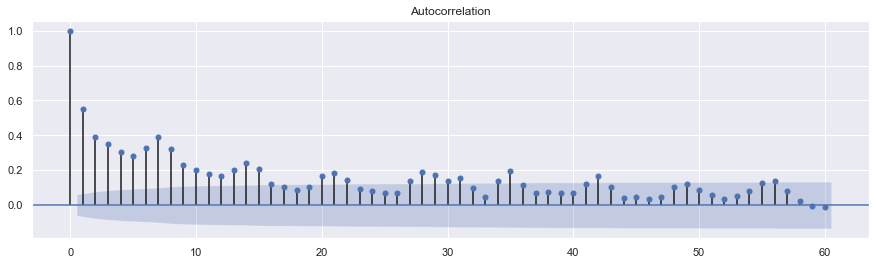

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_acf(ts_daily, alpha=.05, ax=ax, lags=60)
plt.show()

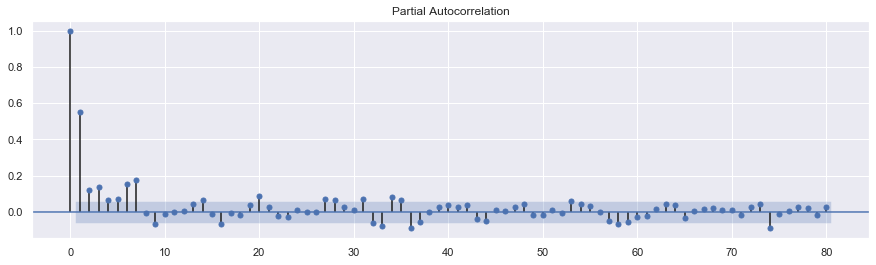

In [10]:
fig1, ax = plt.subplots(figsize=(15, 4))
plot_pacf(ts_daily, alpha=.05, ax=ax, lags=80)
plt.show()

Both suggested a lag of 7, which support the day of week sales relationship as identified in exploratory analysis.

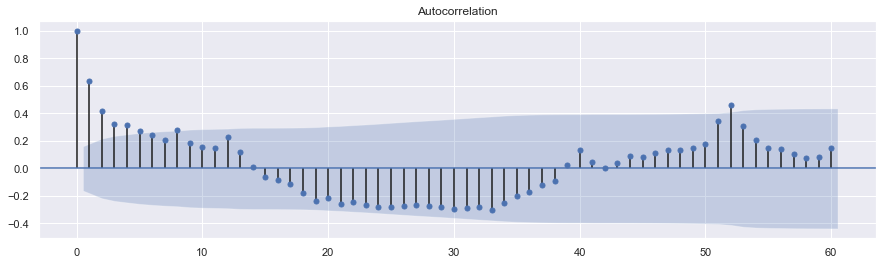

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_acf(ts_weekly, alpha=.05, ax=ax, lags=60)
plt.show()

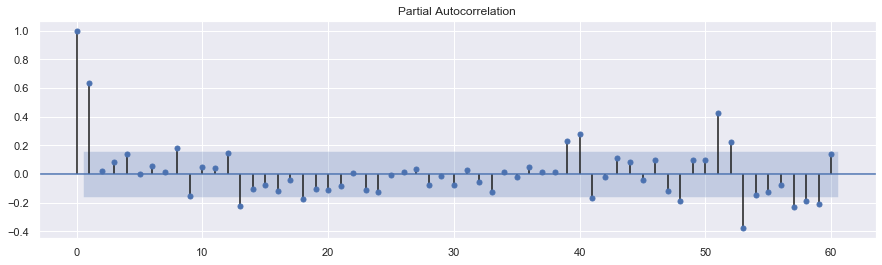

In [12]:
fig1, ax = plt.subplots(figsize=(15, 4))
plot_pacf(ts_weekly, alpha=.05, ax=ax, lags=60)
plt.show()

Strong lags at 2, 3, and 52

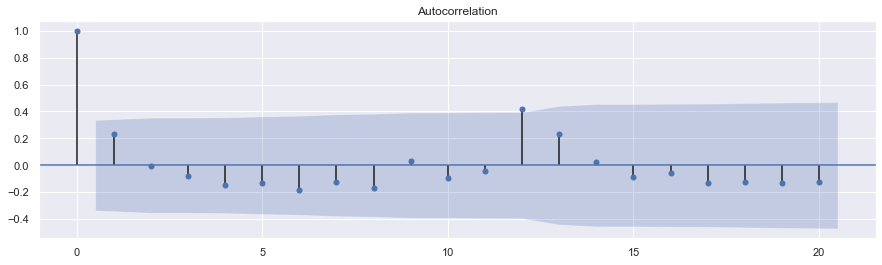

In [13]:
fig2, ax = plt.subplots(figsize=(15, 4))
plot_acf(ts_monthly, alpha=.05, ax=ax, lags=20)
plt.show()

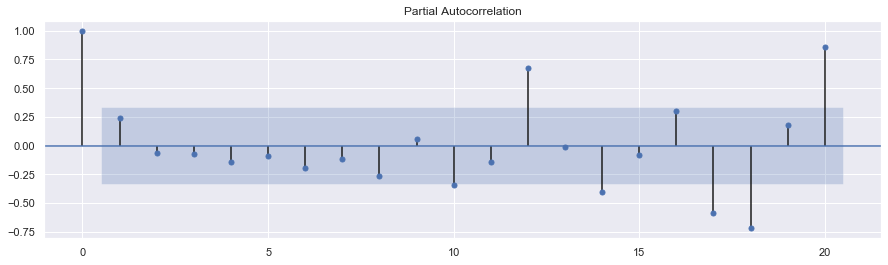

In [14]:
fig3, ax = plt.subplots(figsize=(15, 4))
plot_pacf(ts_monthly, alpha=.05, ax=ax, lags=20)
plt.show()

Strong lag at 12

Monthly partial autocorrelation tend to be a lot more volatile, not recommended to fit model 
<br>
Weekly level show autocorrelation go back up above significant interval, and that's not what we want.
<br>
Daily level seem to satisfy the pattern we want to observed, as the correlation level off after lag of 7. We will go with daily level for now.

In [15]:
conf = 1.96/np.sqrt(len(ts_daily))
print("The approximate confidence interval is +/- %4.2f" %(conf))

The approximate confidence interval is +/- 0.06


### Random Walk Test

**H0**: data follow patten of random walk
<br>
**H1**: data does not follow pattern of random walk

Apply Dickey-Fuller test

In [16]:
results =adfuller(ts_daily)
print(results)
print('p-value is {:.4%}'.format(results[1]))

(-6.018219617770959, 1.5156183061906322e-07, 8, 1025, {'1%': -3.43674585579594, '5%': -2.8643638720413227, '10%': -2.5682735516954196}, 32014.639172088406)
p-value is 0.0000%


We will reject H0 that the data follow random walk pattern.

### Seasonality and Stationary data transformation

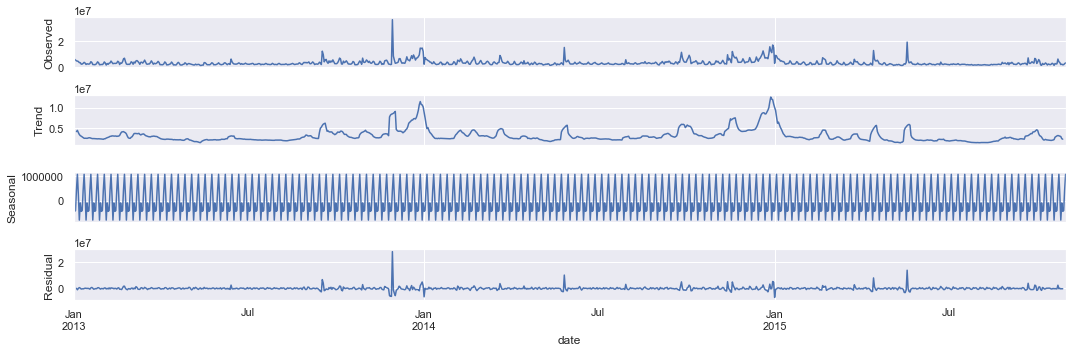

In [17]:
pylab.rcParams['figure.figsize'] = (15, 5)
res= seasonal_decompose(ts_daily)
res.plot();

We can see the seasonality is quite consistent but trend appears to still capturing some seasonal effect. We will try the following ways on removing trend and seasonality

### Differencing

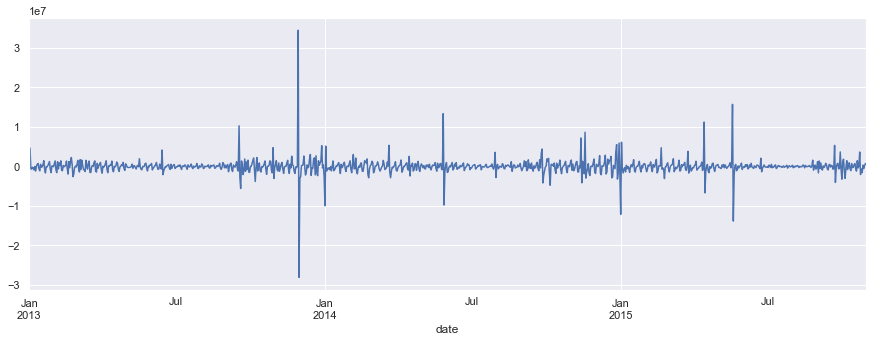

In [18]:
# Using the last day.
ts_daily_shift1 = ts_daily - ts_daily.shift(1)
ts_daily_shift1.dropna()
ts_daily_shift1.plot();

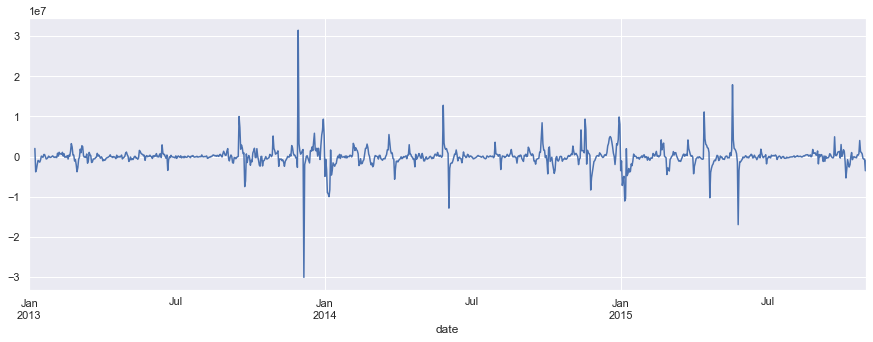

In [19]:
#Using lag of 7
ts_daily_lag = ts_daily - ts_daily.shift(7)
ts_daily_lag.dropna()
ts_daily_lag.plot();

The 7 lag didn't remove more fluctuation in the data than 1 lag. We will use last day differencing.

### Transformation

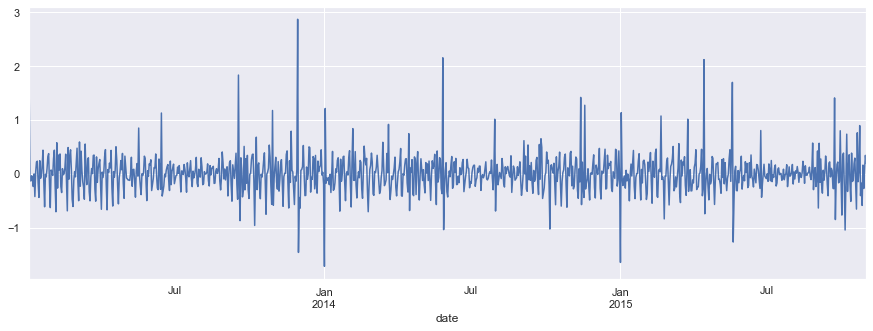

In [20]:
# Log transforming
ts_daily_log = np.log(ts_daily)
ts_daily_log = ts_daily_log - ts_daily_log.shift(1)
ts_daily_log.dropna(inplace=True)
ts_daily_log.plot();

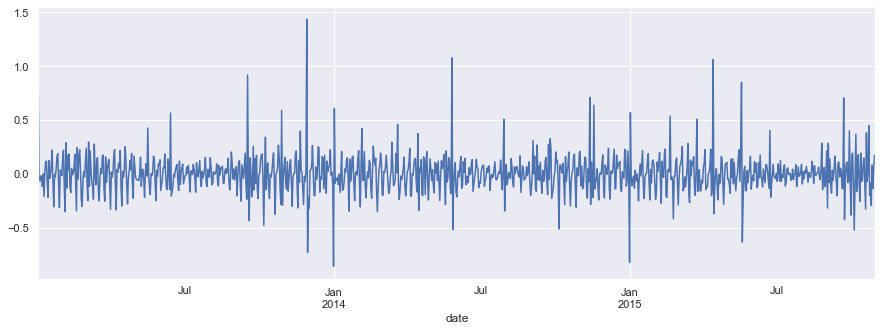

In [21]:
# log + sqrt transforming
ts_daily_logsq = np.log(np.sqrt(ts_daily))
ts_daily_logsq = ts_daily_logsq - ts_daily_logsq.shift(1)
ts_daily_logsq.dropna(inplace=True)
ts_daily_logsq.plot();

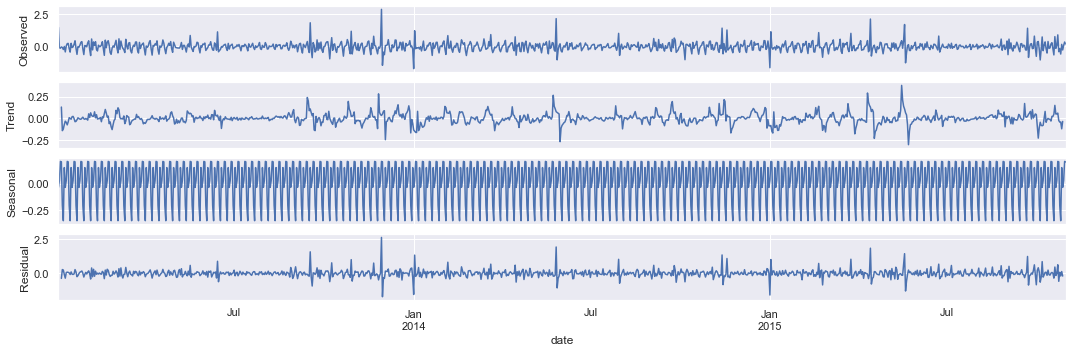

In [22]:
res_log = seasonal_decompose(ts_daily_log)
res_log.plot();

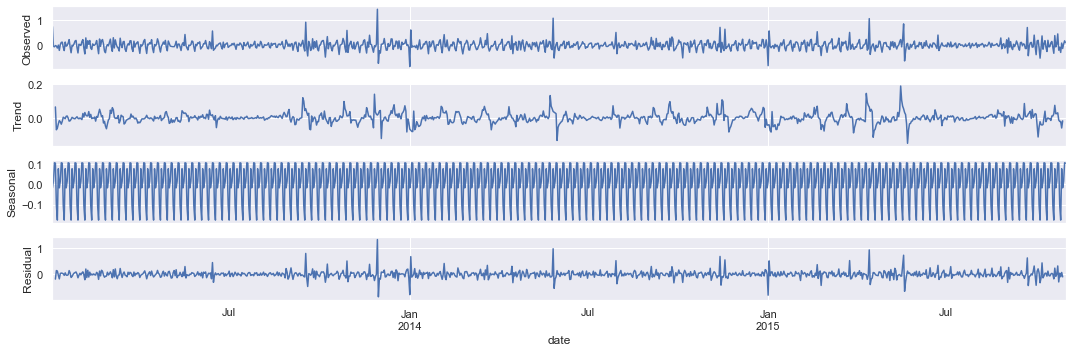

In [23]:
res_logsq = seasonal_decompose(ts_daily_logsq)
res_logsq.plot();

The square root transformation didn't help much on smooth out the data on top of log. We will use only log transformation